### Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
!pip install torchviz

In [2]:
!pip install graphviz

In [3]:
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import random
import sklearn
import time
import matplotlib.pyplot as plt
#import os
import sys

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm import tqdm
from scipy import stats
from torchviz import make_dot
from utils import *

In [5]:
os.environ["PATH"] += os.pathsep + '/opt/conda/lib/python3.11/site-packages/graphviz'

### Experiment Setting

In [6]:
robot_choice = "4DoF-2RPR"
seed = True                                                                   # seed random generators for reproducibility
visualize_joints = True                                                       # visualize joint distribution in dataset     
visualize_workspace = True                                                    # visualize workspace (positions)
visualize_losses = True                                                       # visuallze training and validation losses
visualize_normalized_workspace = True                                         # visualize normalized workspace (positions - debugging purposes)
visualize_workspace_results = True                                            # visualize results in workapce
print_inference_summary = True                                                # perform and print inference summary after training is done
print_epoch = True  
batch_size = 100                                                              # desired batch size
init_type = "default"                                                         # weights init method (default, uniform, normal, xavier_uniform, xavier_normal)
hidden_layer_sizes = [32,32,32,32]                                           # architecture to employ
learning_rate = 1e-4                                                          # learning rate
optimizer_choice = "Adam"                                                      # optimizers (SGD, Adam, Adadelta, RMSprop)
loss_choice = "l2"                                                            # l2, l1, lfk
network_type = "MLP"

EPOCHS = 1000                                                                # total training epochs


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')         # device to train on

In [8]:
if robot_choice == "4DoF-2RPR":
    n_DoF = 4
    input_dim = 3
    output_dim = 4
    
data = pd.read_csv('data_'+robot_choice+'_2.csv')
data

,x,y,z,t1,t2,t3,t4
0,-0.098194,0.139204,0.218765,1.559036,2.413440,0.031235,0.592730
1,-0.005284,0.233037,0.122378,0.965797,1.992017,0.127622,0.992976
2,-0.109576,0.206662,0.156266,1.431398,1.986449,0.093734,0.733938
3,0.373133,0.102294,0.169467,0.070138,0.530486,0.080533,0.795096
4,-0.146554,0.053330,0.201353,2.191788,2.513310,0.048647,0.671394
...,...,...,...,...,...,...,...
19995,0.071428,0.389194,0.187266,1.275780,0.303424,0.062734,0.683083
19996,-0.105358,0.376187,0.157960,1.676974,0.447431,0.092040,0.875621
19997,-0.107143,0.321314,0.214542,1.473924,1.163316,0.035458,0.824888
19998,-0.291024,0.168127,0.099525,2.190749,1.188748,0.150475,0.877858


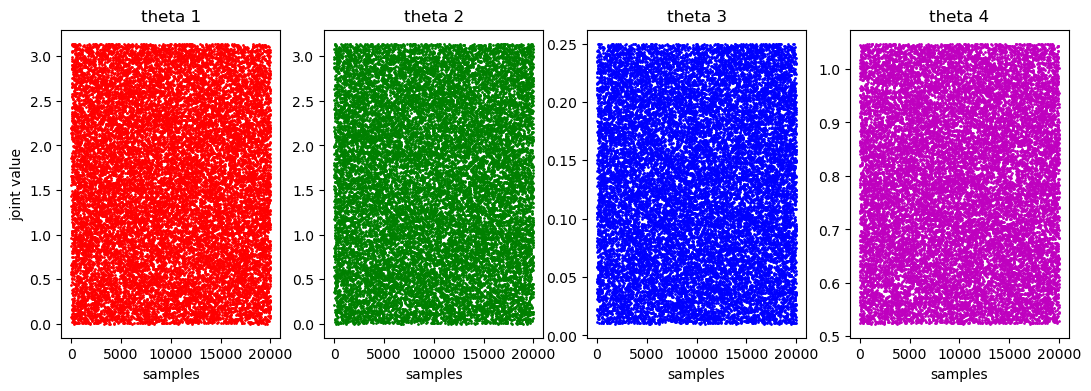

In [9]:
# visualize joints
data_a = np.array(data) 
n_samples = data_a.shape[0]
values = np.linspace(1,n_samples,n_samples)

if visualize_joints:
    """
    fig, axs = plt.subplots(1,4, figsize=(13, 4)) #, sharex=True, sharey=True)
    axs[0].scatter(values, data_a[:,6],s=1, marker='o', c='r')
    axs[0].set(xlabel='samples', ylabel='joint value', title='theta 1')
    axs[1].scatter(values, data_a[:,7],s=1, marker='o', c='g')
    axs[1].set(xlabel='samples', title='theta 2')
    axs[2].scatter(values, data_a[:,8],s=1, marker='o', c='b')
    axs[2].set(xlabel='samples', title='theta 3')
    axs[3].scatter(values, data_a[:,9],s=1, marker='o', c='m')
    axs[3].set(xlabel='samples', title='theta 4')
    """
    
    fig, axs = plt.subplots(1,4, figsize=(13, 4)) #, sharex=True, sharey=True)
    axs[0].scatter(values, data_a[:,3],s=1, marker='o', c='r')
    axs[0].set(xlabel='samples', ylabel='joint value', title='theta 1')
    axs[1].scatter(values, data_a[:,4],s=1, marker='o', c='g')
    axs[1].set(xlabel='samples', title='theta 2')
    axs[2].scatter(values, data_a[:,5],s=1, marker='o', c='b')
    axs[2].set(xlabel='samples', title='theta 3')
    axs[3].scatter(values, data_a[:,6],s=1, marker='o', c='m')
    axs[3].set(xlabel='samples', title='theta 4')


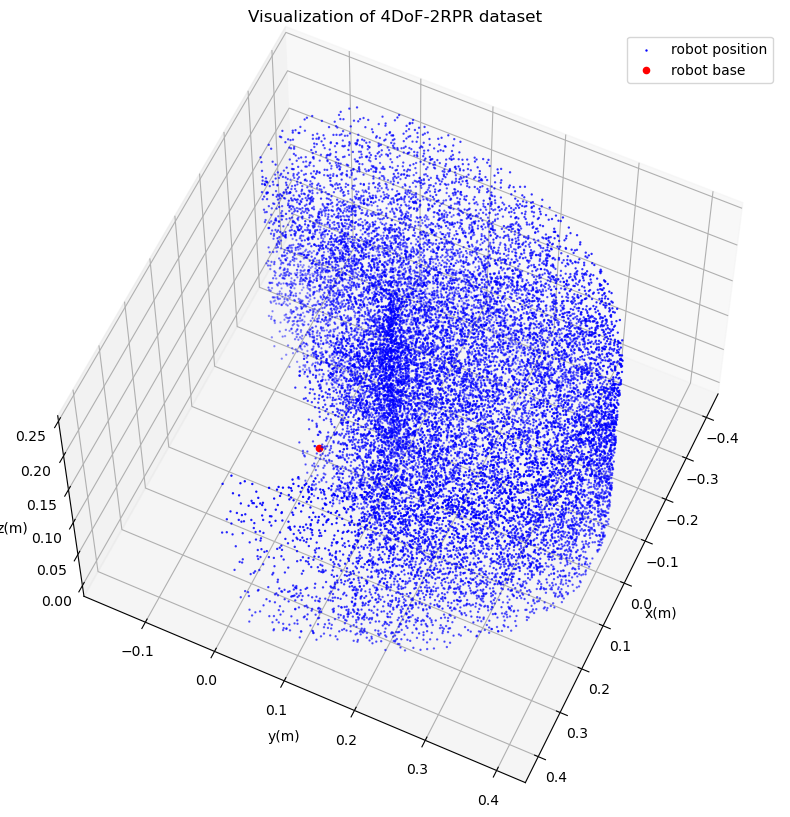

In [10]:
if visualize_workspace:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(data_a[:,0], data_a[:,1], data_a[:,2], s=2, c='b', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='r')
    ax.legend(["robot position","robot base"])
    ax.set(xlabel='x(m)', ylabel='y(m)', zlabel='z(m)',
           title='Visualization of '+robot_choice+ ' dataset')
    ax.view_init(60, 25)
    plt.show()

### Utilities (Classes and Functions)

In [11]:
# vanilla MLP architecture
class MLP_2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.name = "MLP[]"
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]
        batch_size = x.shape[0]
        
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred, h_2

class MLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "MLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        
        self.hidden_fc = nn.ModuleList()
        for i in range(len(self.h_sizes)-1):
            self.hidden_fc.append(nn.Linear(self.h_sizes[i], self.h_sizes[i+1]))
        
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], self.output_dim)

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        #x = self.batch_norm_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        for i in range(len(self.h_sizes)-1):
            x = self.hidden_fc[i](x)
            #x = self.batch_norm_fc(x)
            x = self.relu_activation(x)

        x = self.output_fc(x)
        x_temp = x

        return x, x_temp 


class ResMLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "ResMLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        self.hidden_fc_1 = nn.Linear(self.h_sizes[0], self.h_sizes[1])
        self.hidden_fc_2 = nn.Linear(self.h_sizes[1], self.h_sizes[2])
        self.hidden_fc_3 = nn.Linear(self.h_sizes[2], self.h_sizes[3])
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], self.output_dim)       

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        h1 = self.hidden_fc_1(x)
        h1 = self.relu_activation(h1)

        h2 = self.hidden_fc_2(h1)
        h2 = self.relu_activation(h2)

        h3 = self.hidden_fc_3(h2+h1)
        h3 = self.relu_activation(h3)

        o = self.output_fc(h3+h2+h1)
        x_temp = o

        return o, x_temp 


class DenseMLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "DenseMLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        self.hidden_fc_1 = nn.Linear(self.h_sizes[0], self.h_sizes[1])
        self.hidden_fc_2 = nn.Linear(self.h_sizes[1], self.h_sizes[2])
        self.hidden_fc_3 = nn.Linear(self.h_sizes[2]*2, self.h_sizes[3])
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1]*3, self.output_dim)       

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        h1 = self.hidden_fc_1(x)
        h1 = self.relu_activation(h1)

        h2 = self.hidden_fc_2(h1)
        h2 = self.relu_activation(h2)

        #print(h2.shape)
        #sys.exit(0)

        h3 = self.hidden_fc_3(torch.cat((h2,h1),1))
        h3 = self.relu_activation(h3)

        o = self.output_fc(torch.cat((h3,h2,h1),1))
        x_temp = o

        return o, x_temp 


# count network parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# data loader
class LoadIKDataset(Dataset):
    def __init__(self, inputs_array, outputs_array):
        x_temp = inputs_array
        y_temp = outputs_array

        self.x_data = torch.tensor(x_temp, dtype=torch.float32) 
        self.y_data = torch.tensor(y_temp, dtype=torch.float32) 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        current_input = self.x_data[idx, :]
        current_output = self.y_data[idx, :]
        
        sample = {'input': current_input,
                  'output': current_output}
        return sample
    

    def __len__(self):
        return len(self.x_data)


# function to load the dataset
def load_dataset(data, n_DoF, batch_size):

    # file data_4DoF
    #X = data[:,:3]
    #y = data[:,6:]

    # file data_4DOF_2
    X = data[:,:3]
    y = data[:,3:]

        
    #y = data[:,:2]
    #X = data[:,2:]
        
    # split in train and test sets
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, 
                                                                y, 
                                                                test_size = 0.1,
                                                                random_state = 1)

    sc_in = MinMaxScaler(copy=True, feature_range=(-1, 1))
    sc_out = MinMaxScaler(copy=True, feature_range=(-1, 1))
    
    X_train = sc_in.fit_transform(X_train_i)
    X_test = sc_in.transform(X_test_i)  
    #X_train = X_train_i
    #X_test = X_test_i

    #y_train = sc_out.fit_transform(y_train)
    #y_test = sc_out.transform(y_test) 

    print(X_train.shape)
    print(y_train_i.shape)

    train_data = LoadIKDataset(X_train, y_train_i)
    test_data = LoadIKDataset(X_test, y_test_i)

    train_data_loader = DataLoader(dataset=train_data,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=False)

    test_data_loader = DataLoader(dataset=test_data,
                                   batch_size=1,
                                   shuffle=False)

    return train_data_loader, test_data_loader, X_test_i, y_test_i, X_train, y_train_i

# train function
def train(model, iterator, optimizer, criterion, criterion_type, batch_size, device, epoch, EPOCHS):
    epoch_loss = 0
    model.train()
    i = 0
    
    #with tqdm(total=(len(iterator) - len(iterator) % batch_size)) as t:
    with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
        for data in iterator:
        #for data in tqdm(iterator, desc="Training", leave=False):
            optimizer.zero_grad()
            x, y = data['input'], data['output']
            #print(x)
            #print(y)
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            #print("\nTrain Epoch {} at batch {}".format(epoch, i))
            """
            if i == 1:
                print("\nTrain Epoch {} at batch {}".format(epoch, i))
                print(y_pred[:5,:])
                print(y[:5,:])
                #sys.exit()
            """
            optimizer.zero_grad()
            if criterion_type == "lfk":
                loss = criterion(y_pred, x)
            else:
                loss = criterion(y_pred, y)
            make_dot(loss, params=dict(list(model.named_parameters()))).render("loss", format="png")
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            t.set_postfix_str('Train loss: {:.6f}'.format(epoch_loss/len(iterator)))
            t.update()

            i += 1

            #sys.exit()
    
    
    
    #print("Total batches {}".format(i))
        
    return epoch_loss/len(iterator)

# evaluation function 
def evaluate(model, iterator, criterion, criterion_type, device, epoch, EPOCHS):
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
        #for data in tqdm(iterator, desc="Evaluating", leave=False):        
        with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
            for data in iterator:
                x = data['input'].to(device)
                y = data['output'].to(device)
                y_pred, _ = model(x)
                #loss = criterion(y_pred, y)
                #loss = criterion(y_pred, x)                
                if criterion_type == "lfk":
                    loss = criterion(y_pred, x)
                else:
                    loss = criterion(y_pred, y)
                epoch_loss += loss.item()
    
                t.set_postfix_str('Valid loss: {:.6f}'.format(epoch_loss/len(iterator)))
                t.update()

    return epoch_loss/len(iterator)

# make predictions
def inference(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        #X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    #X_desireds = np.array(X_desireds)
    X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    X_preds = reconstruct_pose(y_preds, robot_choice)

    X_errors = np.abs(X_preds- X_desireds)
    y_errors = np.abs(y_preds- y_desireds)

    X_errors_report = np.array([[X_errors.min(axis=0)],
                                [X_errors.mean(axis=0)],
                                [X_errors.max(axis=0)]],
                                [X_errors.std(axis=0)]).squeeze()
    
    results = {
        "y_preds": y_preds,
        "X_preds": X_preds,
        "y_desireds": y_desireds,
        "X_desireds": X_desireds,
        "X_errors": X_errors_report
    }
    return results

def inference_FK(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    X_desireds = np.array(X_desireds)
    #X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    #X_preds = reconstruct_pose(y_preds, robot_choice)

    #X_errors = np.abs(X_preds - X_desireds)
    y_errors = np.abs(y_preds - y_desireds)

    y_errors_report = np.array([[y_errors.min(axis=0)],
                                [y_errors.mean(axis=0)],
                                [y_errors.max(axis=0)]]).squeeze()
    
    results = {
        "y_preds": y_preds,
        #"X_preds": X_preds,
        "y_desireds": y_desireds,
        #"X_desireds": X_desireds,
        "y_errors": y_errors_report
    }
    return results

# reconstruct positions in cartesian space from predictions
def reconstruct_pose(y_preds, robot_choice):
    y_preds = torch.from_numpy(y_preds)
    n_samples = y_preds.shape[0]
    pose = []
    for i in range(n_samples):
        t = y_preds[i,:]
        DH = get_DH(robot_choice, t)
        T = forward_kinematics(DH)
        if robot_choice == "4DoF-2RPR":
            # x,y,t1,t2,t3 where x,y (m) and t (rad)
            pose.append(T[:3,-1].numpy())
          
    X_pred = np.array(pose)
    return X_pred
    

# compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


# def FFT embedding from this paper: Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = torch.matmul((2*torch.pi*x), B.T)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        


# compute loss function by employing the FK 
class FKLoss(nn.Module):
    def __init__(self):
        super(FKLoss, self).__init__()
        #self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss(reduction="mean")

    def forward(self, inputs, targets):
        #inputs_fk = torch.zeros_like(targets)
        inputs_fk = torch.clone(targets)
        print(inputs_fk)
        for i in range(inputs.shape[0]):
            #print()
            DH = get_DH(robot_choice, inputs[i,:])
            #print(DH)
            T = forward_kinematics(DH)
            #print(T.type)
            inputs_fk[i,:] = T[:3,-1]   

        inputs_fk = inputs_fk
        #print(inputs_fk)
        #print(targets)
        loss = self.criterion(inputs_fk, targets)
        #sys.exit()
        return loss


In [12]:
experiments = 1

for experiment_number in range(experiments):

    # ensure reproducibilities if seed is set to true
    if seed:
        SEED = 3    
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
    ## train and validate
    # load the dataset
    train_data_loader, test_data_loader, X_test, y_test, X_train, y_train = load_dataset(data_a, n_DoF, batch_size)
    
    # get network architecture
    if network_type == "MLP":
        model = MLP(input_dim, hidden_layer_sizes, output_dim)
    elif network_type == "ResMLP":
        model = ResMLP(input_dim, hidden_layer_sizes, output_dim)
    elif network_type == "DenseMLP":
        model = DenseMLP(input_dim, hidden_layer_sizes, output_dim)
        
    
    if init_type == "uniform":
        model.apply(weights_init_uniform_rule)
    elif init_type == "normal":
        model.apply(weights_init_normal_rule)
    elif init_type == "xavier_uniform":
        model.apply(weights_init_xavier_uniform_rule)
    elif init_type == "xavier_normal":
        model.apply(weights_init_xavier_normal_rule)
    elif init_type == "kaiming_uniform":
        model.apply(weights_init_kaiming_uniform_rule)
    elif init_type == "kaiming_normal":
        model.apply(weights_init_kaiming_normal_rule)
        
    model = model.to(device)
    print("==> Architecture: {}\n{}".format(model.name, model))
    print("==> Trainable parameters: {}".format(count_parameters(model)))
    
    # set optimizer
    if optimizer_choice == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_choice == "Adam":
        optimizer = optim.Adam(model.parameters())
    elif optimizer_choice == "Adadelta":
        optimizer = optim.Adadelta(model.parameters())
    elif optimizer_choice == "RMSprop":
        optimizer = optim.RMSprop(model.parameters())
    
    # set loss
    if loss_choice == "l1":
        criterion = nn.MSELoss(reduction="mean")
    elif loss_choice == "l2":
        criterion = nn.L1Loss(reduction="mean")
    elif loss_choice == "lfk":
        criterion = FKLoss()
    
    
    print("\n==> Experiment {} Training network: {}".format(experiment_number+1, model.name))
    print("==> Training device: {}".format(device))
    
    
    # create a directory to save weights
    save_path = robot_choice+"_" \
                +model.name.replace(" ","").replace("[","_").replace("]","_").replace(",","-") \
                +optimizer_choice+"_" \
                +loss_choice+"_" \
                +str(experiment_number+1)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    start_time_train = time.monotonic()
    start_time = time.monotonic()
    for epoch in range(EPOCHS):
        
        train_loss = train(model, train_data_loader, optimizer, criterion, loss_choice, batch_size, device, epoch, EPOCHS)        
        valid_loss = evaluate(model, test_data_loader, criterion, loss_choice, device, epoch, EPOCHS)
    
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path+'/best_epoch.pth')
            best_epoch = epoch
        
        
        
        if epoch % (EPOCHS/10) == 0 or epoch == EPOCHS-1:
        #if epoch % (1) == 0 or epoch == EPOCHS-1:
            if print_epoch:
                end_time = time.monotonic()
                epoch_mins, epoch_secs = epoch_time(start_time, end_time)
                print('Epoch: {}/{} | Epoch Time: {}m {}s'.format(epoch, EPOCHS, epoch_mins, epoch_secs))
                print('\tTrain Loss: {}'.format(train_loss))
                print('\tValid Loss: {}'.format(valid_loss))
                print("\tBest Epoch Occurred [{}/{}]".format(best_epoch, EPOCHS))    
            torch.save(model.state_dict(), save_path+'/epoch_'+str(epoch)+'.pth')
    
    end_time_train = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time_train, end_time_train)
    
    if print_epoch:
        print('\nElapsed Time: {}m {}s'.format(epoch_mins, epoch_secs))    

(18000, 3)
(18000, 4)
==> Architecture: MLP [3, 32, 32, 32, 32, 4]
MLP(
  (input_fc): Linear(in_features=3, out_features=32, bias=True)
  (hidden_fc): ModuleList(
    (0-2): 3 x Linear(in_features=32, out_features=32, bias=True)
  )
  (output_fc): Linear(in_features=32, out_features=4, bias=True)
  (selu_activation): SELU()
  (relu_activation): ReLU()
  (prelu_activation): PReLU(num_parameters=1)
  (lrelu_activation): LeakyReLU(negative_slope=0.01)
  (sigmoid_activation): Sigmoid()
  (batch_norm_fc): BatchNorm1d(20000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
==> Trainable parameters: 43429

==> Experiment 1 Training network: MLP [3, 32, 32, 32, 32, 4]
==> Training device: cuda
Epoch: 0/1000 | Epoch Time: 0m 18s
	Train Loss: 0.45457698793874846
	Valid Loss: 0.2362069097594358
	Best Epoch Occurred [0/1000]
Epoch: 100/1000 | Epoch Time: 36m 16s
	Train Loss: 0.040979373931056925
	Valid Loss: 0.04085117052309215
	Best Epoch Occurred [94/1000]
Epoch: 200/1000 | Epoc

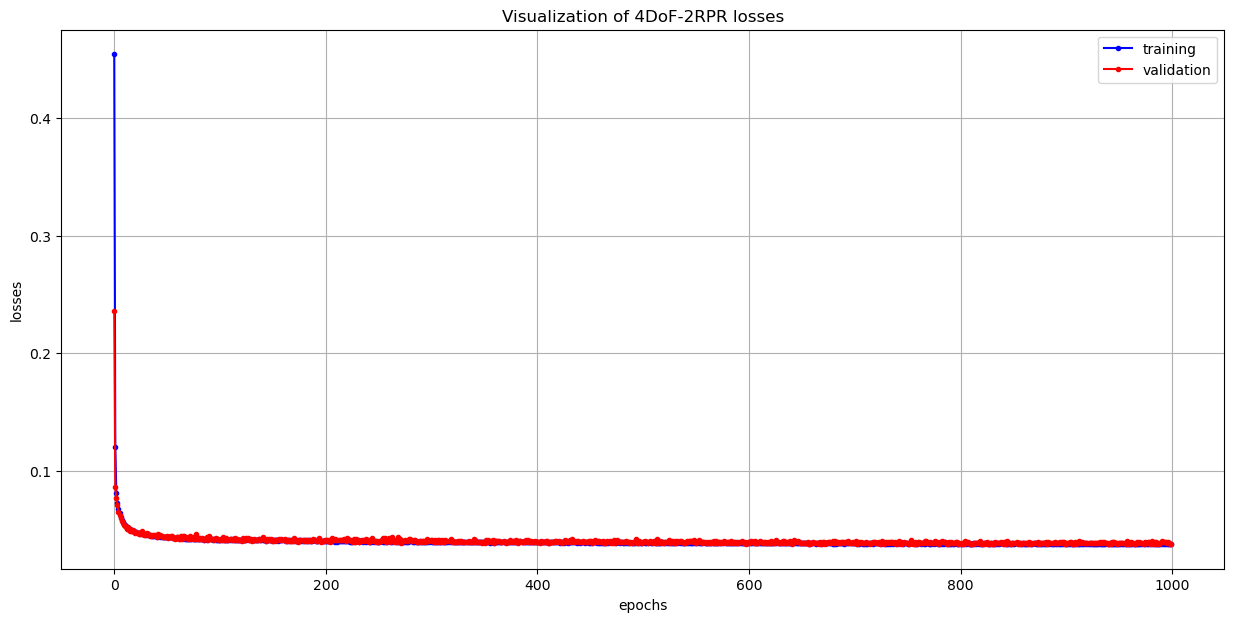

In [13]:
# visualize losses
if visualize_losses:
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(train_losses, marker='.', c='b')
    ax.plot(valid_losses, marker='.', c='r')
    ax.set(xlabel='epochs', ylabel='losses',
           title='Visualization of '+robot_choice+ ' losses')
    ax.legend(["training", "validation"])
    ax.grid()

In [14]:
print(save_path)

4DoF-2RPR_MLP_3-32-32-32-32-4_Adam_l2_1


In [15]:
# inference
if print_inference_summary:
    weights_file = save_path+"/best_epoch.pth"
    if network_type == "MLP":
        model = MLP(input_dim, hidden_layer_sizes, output_dim).to(device)
    elif network_type == "ResMLP":
        model = ResMLP(input_dim, hidden_layer_sizes, output_dim).to(device)
    elif network_type == "DenseMLP":
        model = DenseMLP(input_dim, hidden_layer_sizes, output_dim).to(device)
    
    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)
    
    # get the results from training
    
    results = inference(model, test_data_loader, criterion, device)
    y_preds = results["y_preds"]
    X_preds = results["X_preds"]
    y_desireds = results["y_desireds"]
    X_desireds = results["X_desireds"]
    X_errors = results["X_errors"]
    
    print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
    print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))
    
    print("==> X_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_preds.shape, X_preds.min(), X_preds.mean(), X_preds.max(), X_preds))
    print("==> X_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_test.shape, X_test.min(), X_test.mean(), X_test.max(), X_test))
    
    
    with np.printoptions(precision=4, suppress=True):
        print(X_errors.T*1000)
    #print("X_errors (mm): \n{}".format(X_errors*1000))

    #results = inference_FK(model, test_data_loader, criterion, device)
    #y_preds = results["y_preds"]
    #y_desireds = results["y_desireds"]
    #y_errors = results["y_errors"]
    
    #print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
    #print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))
    #print("y_errors (mm): \n{}".format(y_errors*1000))
    
    
    X_errors_p = np.abs(X_preds - X_desireds)*1000

==> y_preds (2000, 4): min = -0.0115 / mean = 1.0089 / max = 3.1481
[[1.8795005  0.89024746 0.10252928 0.7793301 ]
 [0.03813136 2.5712898  0.24436297 0.7417253 ]
 [2.1736703  0.5646957  0.11508615 0.7654778 ]
 ...
 [3.0819764  0.30051464 0.0611594  0.79585797]
 [0.12017274 2.7142012  0.01437653 0.7735895 ]
 [0.9313116  1.2239662  0.06981294 0.7967993 ]]

==> y_test (2000, 4): min = 0.0002 / mean = 1.0107 / max = 3.1415
[[1.8737766  0.8928162  0.10233442 1.0246218 ]
 [0.04758037 2.5810854  0.24421191 0.6087518 ]
 [2.177438   0.56510323 0.11486035 0.99578595]
 ...
 [3.0886009  0.30615577 0.06182919 0.7304791 ]
 [0.12227935 2.7124817  0.0148312  0.5730739 ]
 [0.9237403  1.2293764  0.07007358 0.6843534 ]]

==> X_preds (2000, 3): min = -0.3991 / mean = 0.0719 / max = 0.4000
[[-0.21570489  0.29268223  0.14747071]
 [ 0.12056214  0.08564137  0.00563703]
 [-0.279723    0.2647856   0.13491386]
 ...
 [-0.39522448 -0.02089107  0.1888406 ]
 [ 0.10522022  0.07533222  0.23562348]
 [ 0.06643045  0.325

In [16]:
if print_inference_summary:
    # percentage of errors less than 1mm, 5mm, 10mm (1cm), 15mm (1.5cm), 20mm (2cm)
    X_percentile = stats.percentileofscore(X_errors_p[:,0], [1,5,10,15,20], kind='rank')
    Y_percentile = stats.percentileofscore(X_errors_p[:,1], [1,5,10,15,20], kind='rank')
    Z_percentile = stats.percentileofscore(X_errors_p[:,2], [1,5,10,15,20], kind='rank')
    print("X_percentile: {}".format(X_percentile))
    print("Y_percentile: {}".format(Y_percentile))
    print("Z_percentile: {}".format(Z_percentile))

X_percentile: [ 60.95 100.   100.   100.   100.  ]
Y_percentile: [ 64.75  99.35 100.   100.   100.  ]
Z_percentile: [ 91.5   99.85 100.   100.   100.  ]


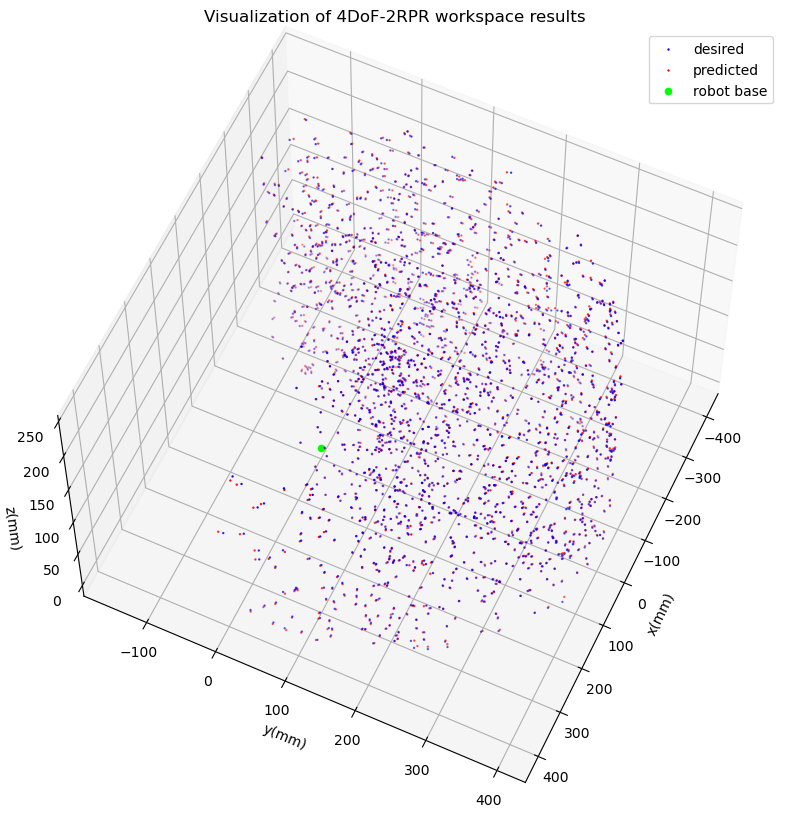

In [17]:
if visualize_workspace_results:
    X_desireds = X_desireds*1000
    X_preds = X_preds*1000    
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_desireds[:,0], X_desireds[:,1], X_desireds[:,2], s=2, c='b', marker='.')
    ax.scatter(X_preds[:,0], X_preds[:,1], X_preds[:,2], s=2, c='r', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='lime')
    ax.legend(["desired", "predicted", "robot base"])
    ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
           title='Visualization of '+robot_choice+ ' workspace results')
    ax.view_init(60, 25)
    plt.show()

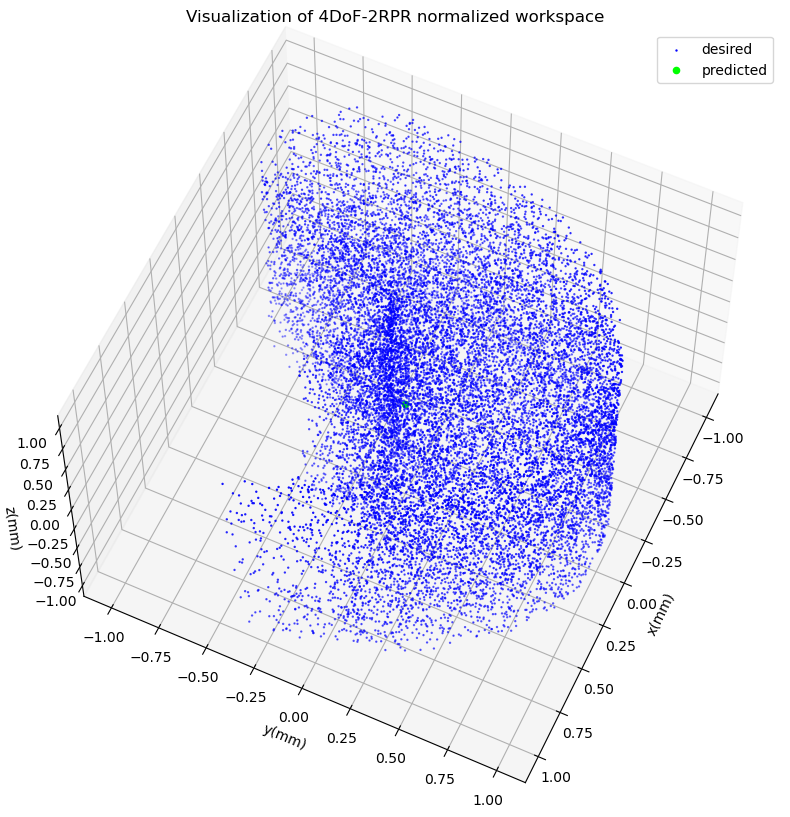

In [18]:
if visualize_normalized_workspace:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], s=2, c='b', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='lime')
    ax.legend(["desired", "predicted", "robot base"])
    ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
           title='Visualization of '+robot_choice+ ' normalized workspace')
    ax.view_init(60, 25)
    plt.show()